In [1]:
# ! module load mambaforge
# ! mamba create -n wind_forecasting_env python=3.12
# ! mamba activate wind_forecasting_env
# ! conda install -c conda-forge jupyterlab mpi4py impi_rt
# ! pip install ./OpenOA # have to change pyproject.toml to allow for python 3.12.7
# ! pip install floris polars windrose netCDF4 statsmodels h5pyd seaborn pyarrow memory_profiler

#%load_ext memory_profiler
from data_loader import DataLoader
from data_filter import DataFilter
from data_inspector import DataInspector
from openoa.utils import qa, plot, filters, power_curve, imputing
import polars.selectors as cs
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import platform
import os
import re
import pandas as pd

[ahenry-39583s:38384] shmem: mmap: an error occurred while determining whether or not /var/folders/15/zl_rr3g10_b5j7bk42pk4dgr4qydb3/T//ompi.ahenry-39583s.159331683/jf.0/2930966528/sm_segment.ahenry-39583s.159331683.aeb30000.0 could be created.
/Users/ahenry/miniconda3/envs/wind_forecasting_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-17 17:28:28,042 - WARNING - /Users/ahenry/miniconda3/envs/wind_forecasting_env/lib/python3.12/site-packages/h5pyd/version.py:23: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _exp = _sv(version)



## Print NetCDF Data Structure, Load Data, Transform Datetime Columns

In [2]:
PLOT = False
RELOAD_DATA = False

if platform == "darwin":
    DATA_DIR = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data"
    # PL_SAVE_PATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data/kp.turbine.zo2.b0.raw.parquet"
    # FILE_SIGNATURE = "kp.turbine.z02.b0.*.*.*.nc"
    PL_SAVE_PATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data/short_kp.turbine.zo2.b0.raw.parquet"
    FILE_SIGNATURE = "kp.turbine.z02.b0.2022030*.*.*.nc"
    MULTIPROCESSOR = "cf"
    TURBINE_INPUT_FILEPATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/ge_282_127.yaml"
    FARM_INPUT_FILEPATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/gch_KP_v4.yaml"
elif platform == "linux":
    DATA_DIR = "/pl/active/paolab/awaken_data/kp.turbine.z02.b0/"
    PL_SAVE_PATH = "/scratch/alpine/aohe7145/awaken_data/kp.turbine.zo2.b0.raw.parquet"
    FILE_SIGNATURE = "kp.turbine.z02.b0.*.*.*.nc"
    MULTIPROCESSOR = "mpi"
    TURBINE_INPUT_FILEPATH = "/projects/aohe7145/toolboxes/wind-forecasting/examples/inputs/ge_282_127.yaml"
    FARM_INPUT_FILEPATH = "/projects/aohe7145/toolboxes/wind-forecasting/examples/inputs/gch_KP_v4.yaml"

DT = 5

data_loader = DataLoader(data_dir=DATA_DIR, file_signature=FILE_SIGNATURE, multiprocessor=MULTIPROCESSOR, save_path=PL_SAVE_PATH, dt=DT,
                         desired_feature_types=["time", "turbine_id", "turbine_status", "wind_direction", "wind_speed", "power_output", "nacelle_direction"],
                         ffill_limit=int(60 * 60 * 10 // DT))

In [3]:
data_loader.print_netcdf_structure(data_loader.file_paths[0])

2024-10-17 17:28:28,063 - INFO - NetCDF File: kp.turbine.z02.b0.20220301.000000.wt028.nc
2024-10-17 17:28:28,063 - INFO - 
Global Attributes:
2024-10-17 17:28:28,063 - INFO - 
Dimensions:
2024-10-17 17:28:28,063 - INFO -   date: 244573
2024-10-17 17:28:28,063 - INFO -   string7: 7
2024-10-17 17:28:28,064 - INFO - 
Variables:
2024-10-17 17:28:28,064 - INFO -   Flag:
2024-10-17 17:28:28,064 - INFO -     Dimensions: ('date', 'string7')
2024-10-17 17:28:28,064 - INFO -     Shape: (244573, 7)
2024-10-17 17:28:28,064 - INFO -     Data type: |S1
2024-10-17 17:28:28,065 - INFO -     Attributes:
2024-10-17 17:28:28,065 - INFO -       _Encoding: utf-8
2024-10-17 17:28:28,065 - INFO -   date:
2024-10-17 17:28:28,065 - INFO -     Dimensions: ('date',)
2024-10-17 17:28:28,065 - INFO -     Shape: (244573,)
2024-10-17 17:28:28,065 - INFO -     Data type: int32
2024-10-17 17:28:28,065 - INFO -     Attributes:
2024-10-17 17:28:28,066 - INFO -       units: milliseconds since 2022-03-01 00:00:00.171000
2

In [4]:
if not RELOAD_DATA and os.path.exists(data_loader.save_path):
    # Note that the order of the columns in the provided schema must match the order of the columns in the CSV being read.
    
    schema = pl.Schema({**{"time": pl.Datetime(time_unit="ms")},
                        **{
                            f"{feat}_{tid}": pl.Float64
                            for feat in ["turbine_status", "wind_direction", "wind_speed", "power_output", "nacelle_direction"] 
                            for tid in [f"wt{d+1:03d}" for d in range(88)]}
                        })
    
    df_query = pl.scan_parquet(source=data_loader.save_path, hive_schema=schema)
    data_loader.available_features = sorted(df_query.collect_schema().names())
    data_loader.turbine_ids = sorted(np.unique([re.findall(f"(?<=wind_direction_)(.*)", feat)[0] for feat in data_loader.available_features if "wind_direction" in feat]))
else:
    df_query = data_loader.read_multi_netcdf()

## Plot Wind Farm, Data Distributions

In [5]:
data_inspector = DataInspector(turbine_input_filepath=TURBINE_INPUT_FILEPATH, farm_input_filepath=FARM_INPUT_FILEPATH)

In [6]:
if PLOT and False:
    data_inspector.plot_wind_farm()

In [7]:
if PLOT:
    data_inspector.plot_wind_speed_power(df_query, turbine_ids=["wt073"])

In [8]:
if PLOT:
    data_inspector.plot_wind_speed_weibull(df_query, turbine_ids=["wt073"])

In [9]:
if PLOT:
    data_inspector.plot_wind_rose(df_query, turbine_ids=["wt073"])

In [10]:
if PLOT:
    data_inspector.plot_correlation(df_query, 
    DataInspector.get_features(df_query, feature_types=["wind_speed", "wind_direction", "nacelle_direction"], turbine_ids=["wt073"]))

In [11]:
if PLOT:
    data_inspector.plot_boxplot_wind_speed_direction(df_query, turbine_ids=["wt073"])

In [12]:
if PLOT:
    data_inspector.plot_time_series(df_query, turbine_ids=["wt073"])

In [13]:
# from datetime import timedelta
# idx = np.where(df_query.select(pl.col("time")).collect(streaming=True).to_series().diff().to_numpy() != np.timedelta64(5, 's'))[0]
# idx

# df_query.select(pl.col("time")).filter(pl.col("time").diff() != np.timedelta64(5, 's')).collect(streaming=True)
# df_query.select("time", "wind_direction_wt073").filter(pl.col("wind_direction_wt073").is_null()).collect(streaming=True)
# df_query.select("time", "power_output_wt073").filter(pl.col("power_output_wt073").is_null()).collect(streaming=True)
# from datetime import datetime
# df_query.select("time", "wind_direction_wt073").filter((pl.col("time") >= datetime.strptime("2022-03-09 00:00:00", '%Y-%m-%d %H:%M:%S')) 
#                                                     & (pl.col("time") <= datetime.strptime("2022-03-17 00:00:00", '%Y-%m-%d %H:%M:%S'))).collect(streaming=True)

## OpenOA Data Preparation & Inspection

In [14]:
ws_cols = DataInspector.get_features(df_query, "wind_speed")
wd_cols = DataInspector.get_features(df_query, "wind_direction")
pwr_cols = DataInspector.get_features(df_query, "power_output")

In [15]:
print(f"Features of interest = {data_loader.desired_feature_types}")
print(f"Available features = {data_loader.available_features}")
# qa.describe(DataInspector.collect_data(df=df_query))

Features of interest = ['time', 'turbine_id', 'turbine_status', 'wind_direction', 'wind_speed', 'power_output', 'nacelle_direction']
Available features = ['nacelle_direction_wt028', 'nacelle_direction_wt033', 'nacelle_direction_wt073', 'power_output_wt028', 'power_output_wt033', 'power_output_wt073', 'time', 'turbine_status_wt028', 'turbine_status_wt033', 'turbine_status_wt073', 'wind_direction_wt028', 'wind_direction_wt033', 'wind_direction_wt073', 'wind_speed_wt028', 'wind_speed_wt033', 'wind_speed_wt073']


In [16]:
if PLOT:
    plot.column_histograms(DataInspector.collect_data(df=df_query, 
    feature_types=DataInspector.get_features(df_query, ["wind_speed", "wind_direction", "power_output", "nacelle_direction"], ["wt073", "wt028", "wt033"])))

In [17]:
data_filter = DataFilter(turbine_availability_col=None, turbine_status_col="turbine_status")

### Remove Inoperational Turbine Rows

In [18]:
# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
# df_query = data_filter.filter_inoperational(df_query, status_codes=[1], include_nan=False)
status_codes = [1]
mask = lambda tid: pl.col(f"turbine_status_{tid}").is_in(status_codes) | pl.col(f"turbine_status_{tid}").is_null()
features = ws_cols + pwr_cols
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, ws_cols + wd_cols, ["wind_speed", "wind_direction"], ["Wind Speed [m/s]", "Wind Direction [deg]"])


Feature wind_speed_wt028 has 70.7668427645553 % unfiltered values.
Feature wind_speed_wt033 has 67.90139425957193 % unfiltered values.
Feature wind_speed_wt073 has 60.64076030717281 % unfiltered values.
Feature power_output_wt028 has 70.7668427645553 % unfiltered values.
Feature power_output_wt033 has 67.90139425957193 % unfiltered values.
Feature power_output_wt073 has 60.64076030717281 % unfiltered values.


In [19]:
# df_query.select(f"power_output_wt073").collect(streaming=True).to_pandas().isna().sum() 
df_query.head().collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null


In [20]:
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
# fill out_of_range measurements with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, ws_cols + wd_cols)

JS Score for feature wind_speed_wt028 = 0.02328274567179356
JS Score for feature wind_speed_wt033 = 0.03544794843578207
JS Score for feature wind_speed_wt073 = 0.03692474764361267
JS Score for feature wind_direction_wt028 = 0.01216459200845605
JS Score for feature wind_direction_wt033 = 0.01136192489625543
JS Score for feature wind_direction_wt073 = 0.016380549342631497


In [21]:
df_query.head().collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null


### Wind Speed Range Filter

In [22]:

# check for wind speed values that are outside of the acceptable range
ws = DataInspector.collect_data(df=df_query, feature_types="wind_speed")
out_of_range = (filters.range_flag(ws, lower=0, upper=70) & ~ws.isna()).values # range flag includes formerly null values as nan
del ws
# qa.describe(DataInspector.collect_data(df=df_query, feature_types="wind_speed", mask=np.any(out_of_range, axis=1)))

# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
mask = lambda tid: ~out_of_range[:, data_loader.turbine_ids.index(tid)]
features = ws_cols
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, ws_cols, ["wind_speed"], ["Wind Speed [m/s]"])



Feature wind_speed_wt028 has 100.0 % unfiltered values.
Feature wind_speed_wt033 has 100.0 % unfiltered values.
Feature wind_speed_wt073 has 100.0 % unfiltered values.


In [23]:
out_of_range
# df_query.select(f"power_output_wt073").collect(streaming=True).to_pandas().isna().sum() 

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [24]:
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
# fill out_of_range measurements with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, ws_cols)
# df_query = df_query.with_columns(
#                 [pl.when(~out_of_range[:, data_loader.turbine_ids.index(feat.split("_")[-1])]).then(pl.col(feat)).alias(feat)
#                 for feat in ws_cols]
#                 )

JS Score for feature wind_speed_wt028 = 0.0
JS Score for feature wind_speed_wt033 = 0.0
JS Score for feature wind_speed_wt073 = 0.0


In [25]:
del out_of_range 
df_query.head().collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null


### Power Curve Window Range Filter

In [26]:
# apply a window range filter to remove data with power values outside of the window from 20 to 3000 kW for wind speeds between 5 and 40 m/s.
# identifies when turbine is shut down, filtering for normal turbine operation

out_of_window = np.stack([(filters.window_range_flag(window_col=DataInspector.collect_data(df=df_query, 
                                                                                    feature_types=["wind_speed"], 
                                                                                    turbine_ids=[tid])[f"wind_speed_{tid}"],
                                                    window_start=5., window_end=40., 
                                                    value_col=DataInspector.collect_data(df=df_query, 
                                                                                    feature_types=["power_output"], 
                                                                                    turbine_ids=[tid])[f"power_output_{tid}"],
                                                    value_min=20., value_max=3000.)
                        & df_query.select(no_nulls=pl.all_horizontal(pl.col(f"wind_speed_{tid}").is_not_null(), pl.col(f"power_output_{tid}").is_not_null()))\
                                  .collect(streaming=True).to_pandas()["no_nulls"]
                                #   & ~DataInspector.collect_data(df=df_query, feature_types="wind_speed", turbine_ids=tid).isna()
                                #   & ~DataInspector.collect_data(df=df_query, feature_types="power_output", turbine_ids=tid).isna()
                                  ).values for tid in data_loader.turbine_ids], axis=1)


# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
mask = lambda tid: ~out_of_window[:, data_loader.turbine_ids.index(tid)]
features = ws_cols + pwr_cols
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, features, ["wind_speed", "power_output"], ["Wind Speed [m/s]", "Power Output [W]"])



Feature wind_speed_wt028 has 98.46890147595447 % unfiltered values.
Feature wind_speed_wt033 has 99.0700397581831 % unfiltered values.
Feature wind_speed_wt073 has 99.15377702739502 % unfiltered values.
Feature power_output_wt028 has 98.46890147595447 % unfiltered values.
Feature power_output_wt033 has 99.0700397581831 % unfiltered values.
Feature power_output_wt073 has 99.15377702739502 % unfiltered values.


In [27]:
# df_query.select(f"power_output_wt033").collect(streaming=True).to_pandas().isna().sum() 
# DataInspector.collect_data(df_query, feature_types=["time", "wind_speed", "power_output"], turbine_ids=["wt073"], mask=out_of_window[:, 2])
out_of_window

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [28]:

if PLOT:
    # plot values that are outside of power-wind speed range
    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=out_of_window,
        flag_labels=("Outside Acceptable Window", "Acceptable Power Curve Points"),
        xlim=(-1, 15),
        ylim=(-100, 3000),
        legend=True,
        scatter_kwargs=dict(alpha=0.4, s=10)
    )


In [29]:
# fill cells corresponding to values that are outside of power-wind speed window range with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, features)

# df_query = df_query.with_columns(
#                 [pl.when(~out_of_window[:, data_loader.turbine_ids.index(feat.split("_")[-1])]).then(pl.col(feat)).alias(feat)
#                 for feat in ws_cols + pwr_cols]
# )

JS Score for feature wind_speed_wt028 = 3.541032279560565e-05
JS Score for feature wind_speed_wt033 = 3.395173905720496e-05
JS Score for feature wind_speed_wt073 = 3.1294921719538925e-05
JS Score for feature power_output_wt028 = 5.8033281632504865e-05
JS Score for feature power_output_wt033 = 1.813105959433226e-05
JS Score for feature power_output_wt073 = 1.7307610666359482e-05


In [30]:
del out_of_window
df_query.head().collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null


In [31]:
#print(df_query.collect(streaming=True).shape)

### Power Curve Bin Filter

In [32]:
# apply a bin filter to remove data with power values outside of an envelope around median power curve at each wind speed

bin_outliers = np.stack([(filters.bin_filter(
                                  bin_col=f"power_output_{tid}", 
                                  value_col=f"wind_speed_{tid}", 
                                  bin_width=50, threshold=3,
                                  center_type="median", 
                                  bin_min=20., bin_max=0.90*(df_query.select(f"power_output_{tid}").max().collect(streaming=True).item() or 3000.),
                                  threshold_type="scalar", direction="below",
                                  data=DataInspector.collect_data(df=df_query, 
                                                                  feature_types=["wind_speed", "power_output"], 
                                                                  turbine_ids=[tid])
                                  )
                                & df_query.select(no_nulls=pl.all_horizontal(pl.col(f"wind_speed_{tid}").is_not_null(), pl.col(f"power_output_{tid}").is_not_null()))\
                                  .collect(streaming=True).to_pandas()["no_nulls"]
                                #   & ~DataInspector.collect_data(df=df_query, feature_types="wind_speed", turbine_ids=tid).isna()
                                #   & ~DataInspector.collect_data(df=df_query, feature_types="power_output", turbine_ids=tid).isna()
                                  ).values for tid in data_loader.turbine_ids], axis=1)
# qa.describe(DataInspector.collect_data(df=df_query, feature_types=["wind_speed", "power_output"], mask=bin_outliers))

# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
mask = lambda tid: ~bin_outliers[:, data_loader.turbine_ids.index(tid)]

features = ws_cols + pwr_cols
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, features, ["wind_speed", "power_output"], ["Wind Speed [m/s]", "Power Output [W]"])

Feature wind_speed_wt028 has 99.98774576548118 % unfiltered values.
Feature wind_speed_wt033 has 99.98502260225479 % unfiltered values.
Feature wind_speed_wt073 has 99.98910734709439 % unfiltered values.
Feature power_output_wt028 has 99.98774576548118 % unfiltered values.
Feature power_output_wt033 has 99.98502260225479 % unfiltered values.
Feature power_output_wt073 has 99.98910734709439 % unfiltered values.


In [33]:
bin_outliers

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [34]:
if PLOT:
    # plot values outside the power-wind speed bin filter
    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=bin_outliers,
        flag_labels=("Anomylous Data", "Normal Wind Speed Sensor Operation"),
        xlim=(-1, 15),
        ylim=(-100, 3000),
        legend=True,
        scatter_kwargs=dict(alpha=0.4, s=10)
    )

In [35]:
# fill cells corresponding to values that are outside of power-wind speed bins with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, features)
# df_query = df_query.with_columns(
#                 [pl.when(~bin_outliers[:, data_loader.turbine_ids.index(feat.split("_")[-1])]).then(pl.col(feat)).alias(feat)
#                 for feat in ws_cols + pwr_cols]
# )

JS Score for feature wind_speed_wt028 = 1.9029505489944738e-08
JS Score for feature wind_speed_wt033 = 1.8675457807432357e-08
JS Score for feature wind_speed_wt073 = 2.747139979315346e-08
JS Score for feature power_output_wt028 = 5.220738859187891e-08
JS Score for feature power_output_wt033 = 5.837710383649833e-08
JS Score for feature power_output_wt073 = 4.389664599272941e-08


In [36]:
df_query.head().collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null


### Power Curve Fitting

In [37]:
if PLOT:
    # Fit the power curves
    iec_curve = power_curve.IEC(
        windspeed_col="wind_speed", power_col="power_output",
        data=DataInspector.unpivot_dataframe(df_query).select("wind_speed", "power_output").filter(pl.all_horizontal(pl.all().is_not_null())).collect(streaming=True).to_pandas(),
        )

    l5p_curve = power_curve.logistic_5_parametric(
        windspeed_col="wind_speed", power_col="power_output",
        data=DataInspector.unpivot_dataframe(df_query).select("wind_speed", "power_output").filter(pl.all_horizontal(pl.all().is_not_null())).collect(streaming=True).to_pandas(),
        )

    spline_curve = power_curve.gam(
        windspeed_col="wind_speed", power_col="power_output",
        data=DataInspector.unpivot_dataframe(df_query).select("wind_speed", "power_output").filter(pl.all_horizontal(pl.all().is_not_null())).collect(streaming=True).to_pandas(), 
        n_splines=20)

In [38]:
if PLOT:
    fig, ax = plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=np.zeros(DataInspector.collect_data(df=df_query, feature_types="wind_speed").shape, dtype=bool),
        flag_labels=("", "Filtered Power Curve"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=False,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10),  # optional input for refining plots
        return_fig=True,
    )

    x = np.linspace(0, 20, 100)
    ax.plot(x, iec_curve(x), color="red", label = "IEC", linewidth = 3)
    ax.plot(x, spline_curve(x), color="C1", label = "Spline", linewidth = 3)
    ax.plot(x, l5p_curve(x), color="C2", label = "L5P", linewidth = 3)

    ax.legend()

    fig.tight_layout()
    plt.show()

### Unresponsive Sensor Filter

In [39]:
# find stuck sensor measurements for each turbine and set them to null
# TODO question does unresponsive flag include nan values
# frozen_thresholds = [(data_loader.ffill_limit * i) + 1 for i in range(1, 19)]
# print(frozen_thresholds)
# ws_pcs = []
# wd_pcs = []
# pwr_pcs = []
# for thr in frozen_thresholds:
#     ws_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_speed"), threshold=thr).values
#     wd_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_direction"), threshold=thr).values
#     pwr_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="power_output"), threshold=thr).values

#     # check if wind speed/dir measurements from inoperational turbines differ from fully operational
#     print(f"For a threshold of {thr} for the frozen sensor filters:")
#     ws_pcs.append(DataInspector.print_pc_unfiltered_vals(df_query, ws_cols, lambda tid: ws_frozen_sensor[:, data_loader.turbine_ids.index(tid)]))
#     wd_pcs.append(DataInspector.print_pc_unfiltered_vals(df_query, wd_cols, lambda tid: wd_frozen_sensor[:, data_loader.turbine_ids.index(tid)]))
#     pwr_pcs.append(DataInspector.print_pc_unfiltered_vals(df_query, pwr_cols, lambda tid: pwr_frozen_sensor[:, data_loader.turbine_ids.index(tid)]))

# fig, ax = plt.subplots(3, 1, sharex=True)
# for t_idx in range(len(data_loader.turbine_ids)):
#     ax[0].scatter(x=frozen_thresholds, y=[x[1][t_idx] for x in ws_pcs], label=data_loader.turbine_ids[t_idx])
#     ax[1].scatter(x=frozen_thresholds, y=[x[1][t_idx] for x in wd_pcs], label=data_loader.turbine_ids[t_idx])
#     ax[2].scatter(x=frozen_thresholds, y=[x[1][t_idx] for x in pwr_pcs],label=data_loader.turbine_ids[t_idx])

# h, l = ax[0].get_legend_handles_labels()
# ax[0].legend(h[:len(data_loader.turbine_ids)], l[:len(data_loader.turbine_ids)])
# ax[0].set_title("Percentage of Unfrozen Wind Speed Measurements")
# ax[1].set_title("Percentage of Unfrozen Wind Direction Measurements")
# ax[2].set_title("Percentage of Unfrozen Power Output Measurements")
# qa.describe(pl.concat([DataInspector.collect_data(df=df_query, feature_types=feature_type, mask=mask, to_pandas=False)
#                         for mask, feature_type in zip([ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor], ["wind_speed", "wind_direction", "power_output"])], 
#                             how="horizontal")\
#                                .to_pandas())

# TODO
if False:
    thr = data_loader.ffill_limit + 1
    # frozen_sensor = (filters.unresponsive_flag(data=df_query.select(features).collect(streaming=True).to_pandas(), threshold=thr)
                                    # & df_query.select([pl.col(feat).is_not_null().alias(feat) for feat in features])\
                                    #   .collect(streaming=True).to_pandas()
                                    #   ).values
    features = ws_cols + wd_cols
    frozen_sensor = np.stack([(filters.unresponsive_flag(data=df_query.select(feat).collect(streaming=True).to_pandas(), threshold=thr)
                                    & df_query.select(pl.col(feat).is_not_null().alias(feat))\
                                    .collect(streaming=True).to_pandas()
                                    ).values for feat in features], axis=1)
    mask = lambda tid: ~frozen_sensor[:, data_loader.turbine_ids.index(tid)]

# df_query.select([pl.col(feat).is_not_null().name.suffix("_not_null") for feat in ws_cols])\
#                                   .collect(streaming=True).to_pandas()
# 
# ws_frozen_sensor = (filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_speed"), threshold=thr)
#                                 & df_query.select([pl.col(feat).is_not_null().name.suffix("_not_null") for feat in ws_cols])\
#                                   .collect(streaming=True).to_pandas()
#                                   ).values
# ws_frozen_sensor
# wd_frozen_sensor = np.stack([(filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_direction"), threshold=thr)
#                                 & df_query.select(no_nulls=pl.col(f"wind_speed_{tid}").is_not_null())\
#                                   .collect(streaming=True).to_pandas()["no_nulls"]
#                                   ).values for tid in data_loader.turbine_ids], axis=1)
# pwr_frozen_sensor = np.stack([(filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="power_output"), threshold=thr)
#                                 & df_query.select(no_nulls=pl.col(f"wind_speed_{tid}").is_not_null())\
#                                   .collect(streaming=True).to_pandas()["no_nulls"]
#                                   ).values for tid in data_loader.turbine_ids], axis=1)

# wd_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_direction"), threshold=thr).values
# pwr_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="power_output"), threshold=thr).values

# ws_mask = lambda tid: ~ws_frozen_sensor[:, data_loader.turbine_ids.index(tid)]
# wd_mask = lambda tid: ~wd_frozen_sensor[:, data_loader.turbine_ids.index(tid)]
# pwr_mask = lambda tid: ~pwr_frozen_sensor[:, data_loader.turbine_ids.index(tid)]


In [40]:
if False:
    frozen_sensor

In [41]:
if PLOT:
    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=ws_frozen_sensor,
        flag_labels=(f"Wind Speed Unresponsive Sensors (n={ws_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=True,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=wd_frozen_sensor,
        flag_labels=(f"Wind Direction Unresponsive Sensors (n={wd_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=True,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=pwr_frozen_sensor,
        flag_labels=(f"Power Output Unresponsive Sensors (n={pwr_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=True,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

In [42]:
# change the values corresponding to frozen sensor measurements to null or interpolate (instead of dropping full row, since other sensors could be functioning properly)
# fill stuck sensor measurements with Null st they are marked for interpolation later,
if False:
    threshold = 0.01
    df_query = data_filter.conditional_filter(df_query, threshold, mask, features)
# df_query = df_query.with_columns(
#                 [pl.when(~frozen_mask[:, data_loader.turbine_ids.index(feat.split("_")[-1])]).then(pl.col(feat)).alias(feat)
#                 for features, frozen_mask in zip(
#                     [ws_cols, wd_cols, pwr_cols], 
#                     [ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor])
#                 for feat in features]
# )

In [43]:
if False:
    del frozen_sensor

### Assess and Impute Turbine Missing Data from Correlated Measurements OR Split Dataset during Time Stamps for which many Turbines have Missing Data

In [44]:
df_query.head().collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null


2024-10-17 17:28:29,145 - WARNING - /Users/ahenry/miniconda3/envs/wind_forecasting_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(



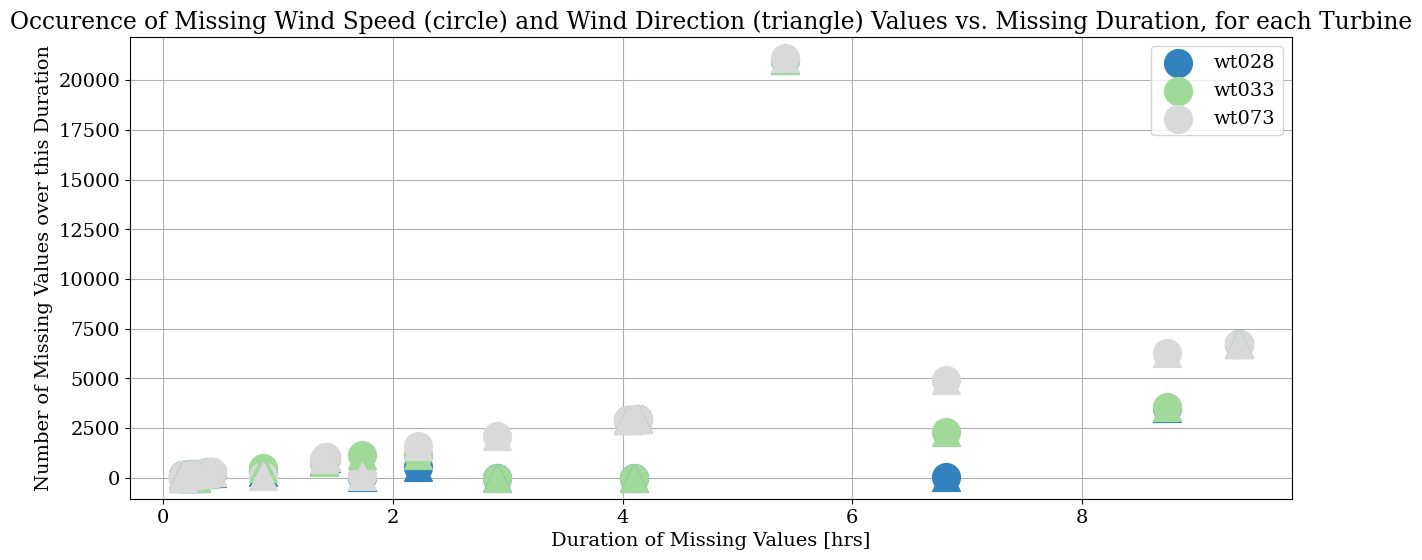

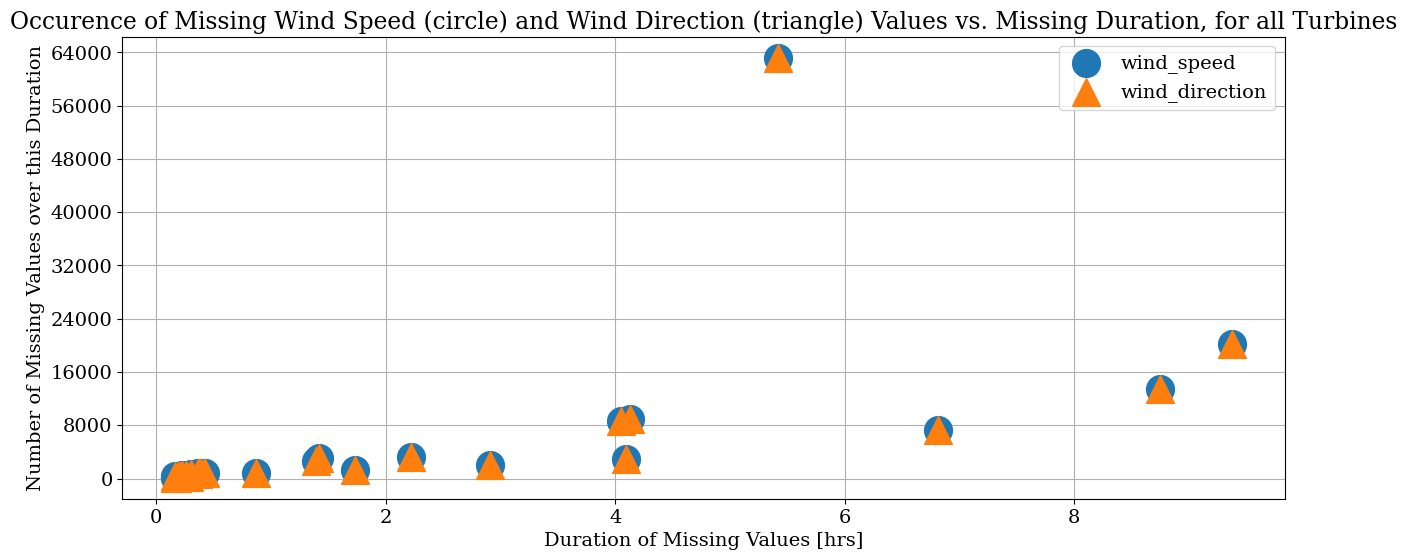

In [45]:
# if there is a short or long gap for some turbines, impute them using the imputing.impute_all_assets_by_correlation function
#       else if there is a short or long gap for many turbines, split the dataset
missing_col_thr = max(1, int(len(data_loader.turbine_ids) * 0.10))
missing_duration_thr = np.timedelta64(10, "m")
missing_data_cols = ["wind_speed", "wind_direction"]

# check for any periods of time for which more than 'missing_col_thr' features have missing data
#.with_columns(num_nulls=pl.sum_horizontal(cs.numeric().is_null()))\

df_query_count_missing = df_query.select(["time"] + [cs.starts_with(col) for col in missing_data_cols])\
        .with_columns(cs.numeric().is_null().name.suffix("_is_missing"))\
        .select("time", cs.ends_with("is_missing"))\
        .with_columns(**{f"{col}_num_missing": pl.sum_horizontal((cs.starts_with(col) & cs.contains("is_missing"))) for col in missing_data_cols})

def add_df_continuity_columns(df, mask):
  # change first value of continuous_shifted to false such that add_df_agg_continuity_columns catches it as a start time for a period 
  return df\
        .filter(mask)\
        .with_columns(dt=pl.col("time").diff())\
        .with_columns(dt=pl.when(pl.int_range(0, pl.len()) == 0).then(np.timedelta64(data_loader.dt, "s")).otherwise(pl.col("dt")))\
        .select("time", "dt", cs.ends_with("num_missing"), cs.ends_with("is_missing"))\
        .with_columns(continuous=pl.col("dt")==np.timedelta64(data_loader.dt, "s"))\
        .with_columns(continuous_shifted=pl.col("continuous").shift(-1, fill_value=True))\
        # .with_columns(continuous_shifted=pl.when(pl.int_range(0, pl.len()) == 0).then(True).otherwise(pl.col("continuous_shifted")))

df_query_not_missing_times = add_df_continuity_columns(df_query_count_missing, mask=pl.sum_horizontal(cs.ends_with("num_missing")) <= missing_col_thr)
df_query_missing_times = add_df_continuity_columns(df_query_count_missing, mask=pl.sum_horizontal(cs.ends_with("num_missing")) > missing_col_thr)

def add_df_agg_continuity_columns(df):
  # if the continuous flag is True, but the value in the row before it False
  df = df.filter(pl.col("continuous") | (pl.col("continuous") & ~pl.col("continuous_shifted")) |  (~pl.col("continuous") & pl.col("continuous_shifted")))
  start_time_cond = ((pl.col("continuous") & ~pl.col("continuous_shifted"))).shift() | (pl.int_range(0, pl.len()) == 0) # TODO start time should start after this point, TODO should account for beginning of time series
  end_time_cond = (~pl.col("continuous") & pl.col("continuous_shifted"))
  return pl.concat([df.filter(start_time_cond).select(start_time=pl.col("time")), 
                    df.with_columns(end_time=pl.col("time").shift(1)).filter(end_time_cond).select("end_time")], how="horizontal")\
            .with_columns(duration=(pl.col("end_time") - pl.col("start_time")))\
            .drop_nulls()

  df.select("time", cs.starts_with("continuous")).filter(
    (pl.col("time") >= df.filter(start_time_cond).select("time").first().collect().item()) 
    & (pl.col("time") < df.filter(end_time_cond).select("time").first().collect().item())).collect()

df_query_not_missing = add_df_agg_continuity_columns(df_query_not_missing_times)
df_query_missing = add_df_agg_continuity_columns(df_query_missing_times)

def get_continuity_group_index(df):
  # Create the condition for the group
  group_number = None

  # Create conditions to assign group numbers based on time ranges
  for i, (start, end) in enumerate(df.select("start_time", "end_time").collect(streaming=True).iter_rows()):
      # print(i, start, end, duration)
      time_cond = pl.col("time").is_between(start, end)
      if group_number is None:
          group_number = pl.when(time_cond).then(pl.lit(i))
      else:
          group_number = group_number.when(time_cond).then(pl.lit(i))
    
  # If no group is matched, assign a default value (e.g., -1)
  group_number = group_number.otherwise(pl.lit(-1))
  return group_number

def group_df_by_continuity(df, agg_df, mask):
  group_number = get_continuity_group_index(agg_df)

  return pl.concat([agg_df, df.with_columns(group_number.alias("continuity_group"))\
          .filter(pl.col("continuity_group") != -1)\
          .group_by("continuity_group")\
          .agg(cs.ends_with("is_missing").sum())\
          .with_columns([pl.sum_horizontal(cs.starts_with(col) & cs.ends_with("is_missing")).alias(f"{col}_is_missing") for col in missing_data_cols])\
          .sort("continuity_group")], how="horizontal")\
          .filter(mask)

df_query_missing = group_df_by_continuity(df_query_missing_times, df_query_missing, mask=pl.col("duration") > missing_duration_thr)
df_query_not_missing = group_df_by_continuity(df_query_not_missing_times, df_query_not_missing, mask=True)

# Plot number of missing wind dir/wind speed data for each wind turbine (missing duration on x axis, turbine id on y axis, color for wind direction/wind speed)
from matplotlib import colormaps
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(1, 1)
for feature_type, marker in zip(missing_data_cols, ["o", "^"]):
  for turbine_id, color in zip(data_loader.turbine_ids, colormaps["tab20c"](np.linspace(0, 1, len(data_loader.turbine_ids)))):
    df = df_query_missing.select("duration", f"{feature_type}_{turbine_id}_is_missing").collect(streaming=True).to_pandas()
    ax.scatter(x=df["duration"].dt.seconds / 3600,
                y=df[f"{feature_type}_{turbine_id}_is_missing"].astype(int),  
    marker=marker, label=turbine_id, s=400, color=color)
ax.set_title("Occurence of Missing Wind Speed (circle) and Wind Direction (triangle) Values vs. Missing Duration, for each Turbine")
ax.set_xlabel("Duration of Missing Values [hrs]")
ax.set_ylabel("Number of Missing Values over this Duration")
h, l = ax.get_legend_handles_labels()
ax.legend(h[:len(data_loader.turbine_ids)], l[:len(data_loader.turbine_ids)])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Plot missing duration on x axis, number of missing turbines on y-axis, marker for wind speed vs wind direction,
fig, ax = plt.subplots(1, 1)
for feature_type, marker in zip(missing_data_cols, ["o", "^"]):
  df = df_query_missing.select("duration", (cs.contains(feature_type) & cs.ends_with("is_missing")))\
                          .with_columns(pl.sum_horizontal([f"{feature_type}_{tid}_is_missing" for tid in data_loader.turbine_ids]).alias(f"{feature_type}_is_missing")).collect(streaming=True).to_pandas()
  ax.scatter(x=df["duration"].dt.seconds / 3600,
              y=df[f"{feature_type}_is_missing"].astype(int),  
  marker=marker, label=feature_type, s=400)
ax.set_title("Occurence of Missing Wind Speed (circle) and Wind Direction (triangle) Values vs. Missing Duration, for all Turbines")
ax.set_xlabel("Duration of Missing Values [hrs]")
ax.set_ylabel("Number of Missing Values over this Duration")
h, l = ax.get_legend_handles_labels()
ax.legend(h[:len(missing_data_cols)], l[:len(missing_data_cols)])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [72]:
# if more than 'missing_col_thr' columns are missing data for more than 'missing_timesteps_thr', split the dataset at the point of temporal discontinuity
split_df_query = [df.lazy() for df in df_query.with_columns(get_continuity_group_index(df_query_not_missing).alias("continuity_group"))\
                          .filter(pl.col("continuity_group") != -1)\
                          .collect(streaming=True)\
                          .sort("time")\
                          .partition_by("continuity_group")]

for df in split_df_query:
    # assert df.select("time").max().item() - df.select("time").min().item()
    assert df.select((pl.col("time").diff(null_behavior="drop") == np.timedelta64(data_loader.dt, "s")).all()).collect(streaming=True).item()
    assert (df.select((pl.sum_horizontal([(cs.numeric() & cs.contains(col)).is_null() for col in missing_data_cols]) <= missing_col_thr).all()).collect(streaming=True).item() 
            |  ((df.select("time").max().collect(streaming=True).item() - df.select("time").min().collect(streaming=True).item()) < missing_duration_thr))

# max_len = 0
# max_idx = -1
# for i, df in enumerate(split_df_query):
#     # print(i, df.collect(streaming=True).shape[0])
#     if (new_len := df.collect(streaming=True).shape[0]) > max_len:
#         max_len = new_len
#         max_idx = i

# print(max_idx, max_len)

In [78]:
col = "wind_direction"
split_df_query[0]
unpivot_df = data_inspector.unpivot_dataframe(split_df_query[0])
split_df_query[0].collect()
unpivot_df.collect()
unpivot_df.collect().to_pandas().set_index(["turbine_id", "time"])


# t1 = unpivot_df.filter(pl.col("wind_direction").is_null()).first().select("time").collect().item()
# split_df_query[0].filter(pl.col("time") >= t1).collect()
# unpivot_df.filter(pl.col("wind_direction").is_null()).collect()

wind_speed  wind_direction  turbine_status  \
turbine_id time                                                              
wt028      2022-03-01 00:00:00    7.267889           210.0             NaN   
           2022-03-01 00:00:05    5.562267           202.0             NaN   
           2022-03-01 00:00:10    5.562267           209.0             NaN   
           2022-03-01 00:00:15    5.921947           207.0             NaN   
           2022-03-01 00:00:20    6.552724           214.0             NaN   
...                                    ...             ...             ...   
wt073      2022-03-01 12:00:10    7.935050           253.0             1.0   
           2022-03-01 12:00:15    7.935050           248.0             1.0   
           2022-03-01 12:00:20    7.935050           248.0             1.0   
           2022-03-01 12:00:25    7.935050           248.0             1.0   
           2022-03-01 12:00:30    8.285666           248.0             1.0   

                                power_output  nacelle_direction  
turbine_id time                                                  
wt028      2022-03-01 00:00:00    744.643555                NaN  
           2022-03-01 00:00:05    749.904358                NaN  
           2022-03-01 00:00:10    735.792847                NaN  
           2022-03-01 00:00:15    719.455200                NaN  
           2022-03-01 00:00:20    706.787231                NaN  
...                                      ...                ...  
wt073      2022-03-01 12:00:10   2125.882810              256.0  
           2022-03-01 12:00:15   2125.882810              256.0  
           2022-03-01 12:00:20   2125.882810              256.0  
           2022-03-01 12:00:25   2125.882810              256.0  
           2022-03-01 12:00:30   2169.476320              256.0  

[25941 rows x 5 columns]

In [76]:
col = "wind_speed"
x=imputing.impute_all_assets_by_correlation(data=unpivot_df.collect(streaming=True).to_pandas().set_index(["turbine_id", "time"]),
                                        impute_col=col, reference_col=col,
                                        asset_id_col="turbine_id", method="linear", r2_threshold=0.9)
print(x)
unpivot_df.collect(streaming=True).to_pandas().set_index(["turbine_id", "time"])
# DataInspector.pivot_dataframe(
# unpivot_df.with_columns(wind_speed=x).collect()
                                                        
                                                        # ).collect()

turbine_id  time               
wt028       2022-03-01 00:00:00    7.267889
            2022-03-01 00:00:05    5.562267
            2022-03-01 00:00:10    5.562267
            2022-03-01 00:00:15    5.921947
            2022-03-01 00:00:20    6.552724
                                     ...   
wt073       2022-03-01 11:59:40         NaN
            2022-03-01 11:59:45         NaN
            2022-03-01 11:59:50         NaN
            2022-03-01 11:59:55         NaN
            2022-03-01 12:00:00         NaN
Name: imputed_wind_speed, Length: 25935, dtype: float64


wind_speed  wind_direction  turbine_status  \
turbine_id time                                                              
wt028      2022-03-01 00:00:00    7.267889           210.0             NaN   
           2022-03-01 00:00:05    5.562267           202.0             NaN   
           2022-03-01 00:00:10    5.562267           209.0             NaN   
           2022-03-01 00:00:15    5.921947           207.0             NaN   
           2022-03-01 00:00:20    6.552724           214.0             NaN   
...                                    ...             ...             ...   
wt073      2022-03-01 11:59:40         NaN             NaN             NaN   
           2022-03-01 11:59:45         NaN             NaN             NaN   
           2022-03-01 11:59:50         NaN             NaN             NaN   
           2022-03-01 11:59:55         NaN             NaN             NaN   
           2022-03-01 12:00:00         NaN             NaN             NaN   

                                power_output  nacelle_direction  
turbine_id time                                                  
wt028      2022-03-01 00:00:00    744.643555                NaN  
           2022-03-01 00:00:05    749.904358                NaN  
           2022-03-01 00:00:10    735.792847                NaN  
           2022-03-01 00:00:15    719.455200                NaN  
           2022-03-01 00:00:20    706.787231                NaN  
...                                      ...                ...  
wt073      2022-03-01 11:59:40           NaN              256.0  
           2022-03-01 11:59:45           NaN              256.0  
           2022-03-01 11:59:50           NaN              256.0  
           2022-03-01 11:59:55           NaN              256.0  
           2022-03-01 12:00:00           NaN              256.0  

[25935 rows x 5 columns]

In [ ]:
# else, for each of those split datasets, impute the values using the imputing.impute_all_assets_by_correlation function 
# imputing.impute_all_assets_by_correlation()
for i, df in enumerate(split_df_query):
    for col in missing_data_cols:
        unpivot_df = data_inspector.unpivot_dataframe(df)
        try:
            imputed_vals = imputing.impute_all_assets_by_correlation(data=unpivot_df.collect().to_pandas().set_index(["turbine_id", "time"]),
                                                        impute_col=col, reference_col=col,
                                                        asset_id_col="turbine_id", method="linear").to_numpy()
            split_df_query[i] = DataInspector.pivot_dataframe(
                unpivot_df.with_columns({col: }))
            print(f"Successfully imputed column {col} in DataFrame {i}.")
        except ValueError as e:
            print(f"Couldn't impute {col} for DataFrame {i} with shape {unpivot_df.collect().shape[0]}")
            print(f"% of missing values = {100 * unpivot_df.select(pl.col(col).is_null()).sum().collect().item() / unpivot_df.select(col).collect(streaming=True).shape[0]}")
            print(f"Full error: {e}")
            
            for other_col in [oc for oc in ["wind_speed", "wind_direction", "power_output", "nacelle_direction"] if oc != col]:
                if unpivot_df.filter(pl.col(col).is_null()).select(other_col).collect().to_series().is_not_null().all():
                    split_df_query[i] = DataInspector.pivot_dataframe(
                        unpivot_df.with_columns({col: pl.col(col).interpolate_by(other_col)})
                    )
                    print(f"Successfully interpolated column {col} in DataFrame {i} using other column {other_col}.")
                    break

# imputing.impute_all_assets_by_correlation(data=data_inspector.unpivot_dataframe(split_df_query[max_idx]).collect(streaming=True).to_pandas().set_index(["turbine_id", "time"]),
#                                                 impute_col="wind_direction", reference_col="wind_direction",
#                                                 asset_id_col="turbine_id", method="linear")

In [ ]:
other_col = "wind_speed"
col = "wind_direction"
unpivot_df.filter(pl.col(col).is_null()).collect()
#.select(other_col).collect(streaming=True).to_series().is_not_null().all():

In [ ]:
# df_query = data_filter.resolve_missing_data(df_query, features=["wind_speed", "wind_direction", "power_output"], how="forward_fill")
# df_query = df_query.pivot(on="turbine_id", index="time", values=["power_output", "nacelle_direction", "wind_speed", "wind_direction", "turbine_status"]).lazy()

## Nacelle Calibration

### Find and correct wind direction offsets from median wind plant wind direction for each turbine

In [ ]:
turbine_ids = df_query.select("turbine_id").unique().collect(streaming=True).to_numpy()[:, 0]

# add the 3 degrees back to the wind direction signal
offset = 3.0
df_query2 = df_query.with_columns((pl.col("wind_direction") + 3.0 % 360.0).alias("wind_direction"))

# TODO make sure that all power values are >= 0 at this point
wd_median = DataInspector.collect_data(df_query2, ["time", "turbine_id", "wind_direction"]).groupby("time")["wind_direction"].median()
wd_median = np.degrees(np.arctan2(np.sin(np.radians(wd_median)), np.cos(np.radians(wd_median))))
wd_median = pd.concat([
    DataInspector.collect_data(df_query2, ["time", "turbine_id", "wind_direction", "power_output"])\
    .pivot(index="time", columns="turbine_id", values="power_output")\
        .rename(columns={old_col: f"power_output_{old_col}" for old_col in turbine_ids}), 
    wd_median], axis=1)

yaw_median = DataInspector.collect_data(df_query2, ["time", "turbine_id", "nacelle_direction"]).groupby("time")["nacelle_direction"].median()
yaw_median = np.degrees(np.arctan2(np.sin(np.radians(yaw_median)), np.cos(np.radians(yaw_median))))
yaw_median = pd.concat([
    DataInspector.collect_data(df_query2, ["time", "turbine_id", "wind_direction", "power_output"])\
    .pivot(index="time", columns="turbine_id", values="power_output")\
        .rename(columns={old_col: f"power_output_{old_col}" for old_col in turbine_ids}), 
    yaw_median], axis=1)

fig, ax = plt.subplots(1, 1)
for turbine_id in turbine_ids:
    df = DataInspector.collect_data(df=df_query2, 
                        features=["time", "turbine_id", "wind_direction", "power_output"], 
                        mask=((pl.col("turbine_id") == turbine_id) & (pl.col("power_output") >= 0)))
                        
    ax.plot(df["time"], DataFilter.wrap_180(
                        df.pivot(index="time", columns="turbine_id", values="wind_direction").values 
                        - wd_median.loc[(wd_median[f"power_output_{turbine_id}"] >= 0), "wind_direction"].values[:, np.newaxis]),
                        label=f"{turbine_id}")

ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Wind Direction - Median Wind Direction (deg)")

ax.set_title("Original")

In [ ]:
#df_query2.select(["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"]).filter(((pl.col("turbine_id") == turbine_id) & (pl.col("power_output") >= 0))).collect(streaming=True)
# DataInspector.collect_data(df=df_query2, 
#                         features=["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"], 
#                         mask=((pl.col("turbine_id") == turbine_id) & (pl.col("power_output") >= 0)))

In [ ]:
df_offsets = {"turbine_id": [], "northing_bias": []}

# remove biases from median direction
for turbine_id in turbine_ids:
    df = DataInspector.collect_data(df=df_query2, 
                        features=["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"], 
                        mask=((pl.col("turbine_id") == turbine_id) & (pl.col("power_output") >= 0)))

    if (turbine_id == f"wt_001"):
        wd_bias = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[(df['time'] >= "2021-08-03 19:20"), "wind_direction"] 
            - wd_median.loc[(df['time'] >= "2021-08-03 19:20") & (wd_median[f'power_output_{turbine_id}'] >= 0)]))
        yaw_bias = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[(df['time'] >= "2021-08-03 19:20"), "nacelle_direction"] 
        - yaw_median.loc[(df['time'] >= "2021-08-03 19:20") & (yaw_median[f'power_output{turbine_id}' % i] >= 0)]))
    else:
        wd_bias = DataFilter.wrap_180(DataFilter.circ_mean(df["wind_direction"] - wd_median.loc[wd_median[f"power_output_{turbine_id}"] >= 0, "wind_direction"]))
        yaw_bias = DataFilter.wrap_180(DataFilter.circ_mean(df["nacelle_direction"] - yaw_median.loc[yaw_median[f"power_output_{turbine_id}"] >= 0, "nacelle_direction"]))

    df_offsets["turbine_id"].append(turbine_id)
    df_offsets["northing_bias"].append(np.round(0.5 * (wd_bias + yaw_bias), 2))
        
    if (turbine_id != f"wt_040"):
        df.loc[df["turbine_id"] == turbine_id, "wind_direction"] = (df.loc[df["turbine_id"] == turbine_id, "wind_direction"] - 0.5 * (wd_bias + yaw_bias)) % 360
        df.loc[df["turbine_id"] == turbine_id, "nacelle_direction"] = (df.loc[df["turbine_id"] == turbine_id, "nacelle_direction"] - 0.5 * (wd_bias + yaw_bias)) % 360
        print(f"Turbine {turbine_id} bias from median wind direction: {np.round(0.5 * (wd_bias + yaw_bias), 2)} deg.")

df_offsets = pd.DataFrame(df_offsets)
# handle special case of turbine 39 with a couple change points
"""
tid = "wd_040"
df = DataInspector.collect_data(df=df_query2, 
                        features=["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"], 
                        mask=((pl.col("turbine_id") == tid) & (pl.col("power_output") >= 0)))
wd_bias_1 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] <= "2021-06-09 19:30"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] <= "2021-06-09 19:30") 
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

wd_bias_2 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-06-09 19:40")
    & (df['time'] <= "2021-09-14 19:50"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] >= "2021-06-09 19:30")
            & (wd_median['time'] <= "2021-09-14 19:50")   
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

wd_bias_3 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-09-14 20:00"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] >= "2021-09-14 20:00")
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_1 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] <= "2021-06-09 19:30"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] <= "2021-06-09 19:30") 
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_2 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-06-09 19:40")
    & (df['time'] <= "2021-09-14 19:50"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] >= "2021-06-09 19:30")
            & (yaw_median['time'] <= "2021-09-14 19:50")   
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_3 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-09-14 20:00"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] >= "2021-09-14 20:00")
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

cond = (df['time'] <= "2021-06-09 19:30")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_1 + yaw_bias_1)) % 360
df.loc[cond, "nacelle_direction"] = (df[cond, "nacelle_direction"] - 0.5 * (wd_bias_1 + yaw_bias_1)) % 360

cond = (df['time'] >= "2021-06-09 19:40") & (df['time'] <= "2021-09-14 19:50")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_2 + yaw_bias_2)) % 360
df.loc[cond, "nacelle_direction"] = (df.loc[cond, "nacelle_direction"] - 0.5 * (wd_bias_2 + yaw_bias_2)) % 360

cond = (df['time'] >= "2021-09-14 20:00")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_3 + yaw_bias_3)) % 360
df.loc[cond, "nacelle_direction"] = (df.loc[cond, "nacelle_direction"] - 0.5 * (wd_bias_3 + yaw_bias_3)) % 360

print("Biases from median wind direction for turbine 39:")

print(f"wd_bias_1: {wd_bias_1}")
print(f"wd_bias_2: {wd_bias_2}")
print(f"wd_bias_3: {wd_bias_3}")

print(f"yaw_bias_1: {yaw_bias_1}")
print(f"yaw_bias_2: {yaw_bias_2}")
print(f"yaw_bias_3: {yaw_bias_3}")

plt.figure()
for turbine_id in turbine_ids:
    plt.plot(df["time"], 
    DataFilter.wrap_180(df["wind_direction"].values - wd_median.loc[wd_median[f"power_output_{turbine_id}"] >= 0, "wind_direction"].values))

plt.xlabel("Time (s)")
plt.ylabel("Wind Direction - Median Wind Direction (deg)")
plt.title("Corrected")

# specific time of changepoints for turbine 39: 6/9 19:35:55; 9/14 19:55:02
"""
# make sure we have corrected the bias between wind direction and yaw position by adding 3 deg. to the wind direction
bias = 0
for turbine_id in turbine_ids:
    df = DataInspector.collect_data(df=df_query2, 
                        features=["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"], 
                        mask=((pl.col("turbine_id") == turbine_id) & (pl.col("power_output") >= 0)))[["wind_direction", "nacelle_direction"]]
    bias += DataFilter.wrap_180(DataFilter.circ_mean(df["wind_direction"] - df["nacelle_direction"]))
    
print(f"Average Bias = {bias / len(turbine_ids)}")

### Find offset to true North using wake loss profiles

In [162]:
# TODO Optimization function for finding waked direction
def gauss_corr(gauss_params, power_ratio):
    xs = np.array(range(-int((len(power_ratio) - 1) / 2), int((len(power_ratio) + 1) / 2), 1))
    gauss = -1 * gauss_params[2] * np.exp(-0.5 * ((xs-gauss_params[0]) / gauss_params[1])**2) + 1.
    return -1 * np.corrcoef(gauss, power_ratio)[0, 1]

In [ ]:
# TODO Find offsets between direction of alignment between pairs of turbines 
# and direction of peak wake losses. Use the average offset found this way 
# to identify the Northing correction that should be applied to all turbines 
# in the wind farm.
from scipy.stats import norm
from scipy.optimize import minimize

from floris import FlorisModel
fi = FlorisModel(data_inspector.farm_input_filepath)

p_min = 100
p_max = 2500

prat_hfwdth = 30

prat_turbine_pairs = [(61,60), (51,50), (43,42), (41,40), (18,19), (34,33), (17,16), (21,22), (87,86), (62,63), (32,33), (59,60), (42,43)]

dir_offsets = []

for i in range(len(prat_turbine_pairs)):
    i_up = prat_turbine_pairs[i][0]
    i_down = prat_turbine_pairs[i][1]

    dir_align = np.degrees(np.arctan2(fi.layout_x[i_up] - fi.layout_x[i_down], fi.layout_y[i_up] - fi.layout_y[i_down])) % 360

    # df_sub = df_10min.loc[(df_10min['pow_%03d' % i_up] >= p_min) & (df_10min['pow_%03d' % i_up] <= p_max) & (df_10min['pow_%03d' % i_down] >= 0)]

    df_sub = df_query.filter(((pl.col("turbine_id") == f'wt{i_up:03d}') 
                              & (pl.col("power_output") >= p_min) 
                              & (pl.col("power_output") <= p_max)) 
                  | ((pl.col("turbine_id") == f'wt{i_down:03d}') 
                     & (pl.col("power_output") >= 0)))
    print(df_query.filter(pl.col("turbine_id") == f'wt{i_up:03d}').collect(streaming=True))
    
    # df_sub.loc[df_sub['wd_%03d' % i_up] >= 359.5,'wd_%03d' % i_up] = df_sub.loc[df_sub['wd_%03d' % i_up] >= 359.5,'wd_%03d' % i_up] - 360.0
    df_sub = df_sub.with_columns(pl.when((pl.col("turbine_id") == f'wt{i_up:03d}') & (pl.col("wind_direction") >= 359.5))\
                                     .then(pl.col("wind_direction") - 360.0)\
                                     .otherwise(pl.col("wind_direction"))\
                                     .alias("wind_direction"))
    # df_sub["wd_round"] = df_sub[f'wd_{i_up:03d}'].round()
    df_sub = df_sub.with_columns(pl.col("wind_direction").round().alias("wind_direction_round"))

    df_sub = df_sub.group_by("wind_direction_round").mean().collect(streaming=True).to_pandas()

    p_ratio = df_sub.loc[df_sub["turbine_id"] == f"wt{i_down:03d}", f'power_output'] \
        / df_sub.loc[df_sub["turbine_id"] == f"wt{i_up:03d}", f'power_output']

    plt.figure()
    plt.plot(p_ratio, label="_nolegend_")
    plt.plot(dir_align * np.ones(2),[0,1.25], 'k--', label="Direction of Alignment")
    plt.grid()

    nadir = np.argmin(p_ratio[np.arange(int(np.round(dir_align)) - prat_hfwdth,int(np.round(dir_align)) + prat_hfwdth + 1) % 360])
    nadir = nadir + int(np.round(dir_align)) - prat_hfwdth

    opt_gauss_params = minimize(gauss_corr, [0, 5.0, 1.0], args=(p_ratio[np.arange(nadir-prat_hfwdth,nadir + prat_hfwdth + 1) % 360]),method='SLSQP')

    xs = np.array(range(-int((60 - 1) / 2),int((60 + 1) / 2),1))
    gauss = -1 * opt_gauss_params.x[2] * np.exp(-0.5 * ((xs - opt_gauss_params.x[0]) / opt_gauss_params.x[1])**2) + 1.

    plt.plot(xs + nadir, gauss,'k',label="_nolegend_")
    plt.plot(2 * [nadir + opt_gauss_params.x[0]], [0,1.25], 'r--',label="Direction of Measured Wake Center")
    plt.title(f"Turbine Pair: ({i_up}, {i_down})")
    plt.legend()
    plt.xlabel("Wind Direction (deg)")
    plt.ylabel("Power Ratio (-)")
    
    dir_offset = DataFilter.wrap_180(nadir + opt_gauss_params.x[0] - dir_align)
    print(dir_offset)

    dir_offsets = dir_offsets + [dir_offset]

print(f"Mean offset = {np.mean(dir_offsets)}")
print(f"Std. Dev. = {np.std(dir_offsets)}")
print(f"Min. = {np.min(dir_offsets)}")
print(f"Max. = {np.max(dir_offsets)}")

## Normalization